<a href="https://colab.research.google.com/github/brenocavi/predict_with_prophet/blob/main/Projeto_Previs%C3%A3o_de_Demanda_com_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**


---

# PREVISÃO DE DEMANDA



Qualquer estabelecimento que trabalhe com vendas de produtos têm como uma das sus principais obrigações, o controle do estoque. A má adiministração destes departamento pode ser falta para a saúde da empresa, seja pela falta de produto e consequentemente perde de cliente, seja pelo execesso de produto que resulta na perda de mercadoria. 

<p align=center>
<img src=https://blog.jetbov.com/wp-content/uploads/2020/01/estoque-2.png>
</p>

Com isso em mente, utilizar os dados históricos de vendas pode trazer grandes vantagens para a empresa, além de dar vantagem competitiva contra os concorrêntes. Segundo [estudo da Capgemini](https://www.capgemini.com/br-pt/news/fabricantes-de-produtos-de-consumo-e-varejistas-devem-acelerar-sua-maturidade-analitica-para-se-tornarem-mais-resilientes-pos-covid-19/), as empresas que utilizam de dados para o controle do estoque, conseguem ter uma margem de lucro 30% maior do que os concorrêntes.

Neste trabalho em específico a loja alvo de análise trabalha com a venda de vinhos. Por se tratar de uma loja de vinhos, o controle do estoque se faz de extrema importância, uma vez que, o produto necessita de alguns cuidados como: 

* Não ficar guardado por longos períodos para não perder as caracteristicas;
* Evitar ambientes que as garrafas serão movidas em demasia, ou cause vibrações nas garrafas; 
* Variações de temperatura também podem afetar o sabor do vinho,  por isso é necessário locais fresco e longe de luz natural;
* É preciso planejar as compras dos produto de acordo não só com a necessidade do cliente mas também com as épcocas de produção. 

Os pontos descritos acima são apenas alguns exmeplos que devem ser levados em consideração, e que podem ser afetar todo o estoque se não receberem a devida atenção.

## Descrição do projeto 

<p aling=center>
<img src=https://www.ibahia.com/wp-content/uploads/fileadmin/representativas/RTEmagicC_adega_vila_rossa.jpg-1200x675.jpg>
</p>

O projeto desenvolvido a seguir, conta a análise de dados 100% sintétcos, ou seja, foram criados tomando por base dados utlizados em uma competição no Kaggle. Os dados foram divididos em dois Datasets, um com os dados de vinhos e ou outro com as vendas. Você pode ver os dados a seguir: 

* [Dados sobre os produtos](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv)
* [Dados de Vendas](https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv)

O dados de vendas possuem intervalo de 2018-2020, e descreve as vendas diárias de cada produto e estão separas ainda entre 3 lojas. O dados de produto, possuem a descrição do tipo, safra, produtor e região que foi produzida. 

O objetivo é analisar os dados historicos de vendas, para realizar previsões para os meses subsequentes. Como previsões para períodos maiores apresentam maiores erros, a previsão será feita para 6 meses, que já pode ser considerado um período longo.

##Premissas Iniciais

* Período de festivo de final de ano, apreseterá alta nas vendas;
* Provavelmente os vinhos mais baratos e os mais caros, serão os que tem maior saída;
* O vinho de maior fluxo de venda, não é o que gera maior faturamento.


##Dicionario de Variáveis 

Dados sobre os produtos:

* **item_id:** Código de identificação individual de cada vinho;
* **name:** Nome do vinho; 
* **producer:** Podutor do vinho;
* **country:** País onde é produzido o vinho;
* **region:** Região do país onde é produzido o vinho;
* **vintage:** Ano de melhor safra;
* **kind:** Tipo do vinho:
  * Red: Tinto
  * White: Branco
  * Sparkling: Espumante
  * Rose Sparkling: Espumante rose
  * Rose: Rosé
* **price_brl:** Preço em reais;
* **price_usd:** Preço em dolares.

Dados sobre as vendas:

* **date:** Data da venda;
* **store:** Código da loja;
* **item:** Código de identificação do vinho;
* **sales:** Total de vendas realizadas individualizadas por vinhos e data.

 

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

In [ ]:
#indicando os caminhos
data_path_product = 'https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/products.csv'
data_path_sells = 'https://raw.githubusercontent.com/rafaelnduarte/sigmoidal_data/master/sales-clean.csv'

#Importar Dataset produtos 
df_prod = pd.read_csv(data_path_product)
df_sells = pd.read_csv(data_path_sells)

Para facilitar algumas etapas repetitivas foi criado algumas funções 

In [ ]:
def making_float(df):
  """Converte uma coluna com valor 
  número que está como string em float.
  Aqui especificamente será empregada 
  apenas nos valores de preços
  
  Requesito:
  Df = O dataset com a coluna que se 
  deseja converter
  """
  #arrumar o a strip
  df =df.apply(lambda x: x.replace(",", "").strip())
  #treansformar para float
  df =df.apply(lambda x: float(x))

  return df



##Análise Exploratória - Produtos

Neste primeiro passo precisamos entener os dados com os quais trabalharemos, com isso vamos primiero veremos o Dataset de produtos.

In [ ]:
df_prod.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,NV,sparkling,339.60,58.75
1,2,Philipponnat Royale Reserve Rosé,Philipponat,France,Champagne,NV,rose sparkling,489.00,84.60
2,3,Philipponnat Cuvée 1522 Grand Cru Extra Brut,Philipponat,France,Champagne,2009,sparkling,789.00,136.51
3,4,Philipponnat Cuvée 1522 1er Cru Rosé,Philipponat,France,Champagne,2008,rose sparkling,899.40,155.61
4,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,"1,548.00",267.82


Temos o total de 219 entradas. Todos os dados estão classificados como object, porém, temos colunas onde os dados deveriam serem númericos, como nas colunas de *price_brl*, *price_usd* e *vintage*. Aparentemente não existem dados ausentes, olhando para o descritivo abaixo, porém é bom verificar após a reclassificação destes dados. 

In [ ]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    219 non-null    int64 
 1   name       219 non-null    object
 2   producer   219 non-null    object
 3   country    219 non-null    object
 4   region     219 non-null    object
 5   vintage    219 non-null    object
 6   kind       219 non-null    object
 7   price_brl  219 non-null    object
 8   price_usd  219 non-null    object
dtypes: int64(1), object(8)
memory usage: 15.5+ KB


Cada produto possui um identificador próprio, porém, se olharmos pelo nome vemos que existem vinhos repetidos 

In [ ]:
df_prod.nunique()

item_id      219
name         188
producer      58
country        6
region        21
vintage       17
kind           5
price_brl    123
price_usd    121
dtype: int64

Vemos que a loja de vinhos vendo mais vinhos europeus, mais especificamente produzidos na região francesas de Burgundy e Bordeaux.

In [ ]:
df_prod['country'].value_counts()

France       154
Italy         23
Spain         18
Portugal      15
Argentina      8
Chile          1
Name: country, dtype: int64

In [ ]:
df_prod.groupby(["country", "region"])['item_id'].count()

country    region          
Argentina  Mendoza              8
Chile      Maipo                1
France     Alsace               1
           Bordeaux            47
           Burgundy            70
           Champagne            9
           Loire Valley         5
           Provence             5
           Rhone               13
           Sud Ouest            4
Italy      Campania             4
           Piedmont             5
           Puglia               3
           Toscana              8
           Veneto               3
Portugal   Alentejo             8
           Douro                7
Spain      Navarra              4
           Penedès              1
           Ribera del Duero     5
           Rioja                8
Name: item_id, dtype: int64

Como o dataset contém nome reptidos de alguns vinhos, usei o méotodo duplicated() para verificar visualmente esses dados. A seguir vemos, que apesar de alguns produtos terem o mesmo nome, são vinhos de safras(vintage) diferentes por isso terão caracteristicas diferenciadas, o que reflete no preço. Assim sendo, será mantido todos os dados neste dataset de produtos. 

In [ ]:
duplicated = df_prod.duplicated(subset='name')
df_prod[duplicated]

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
33,34,La Chablisienne Chablis Grand Cru Les Preuses,La Chablisienne,France,Burgundy,2004,white,549.60,95.09
36,37,Domaine Michel Niellon Chassagne-Montrachet,Domaine Michel Niellon,France,Burgundy,2018,white,619.20,107.13
47,48,Domaine Matrot Meursault 1er Cru Blagny,Domaine Matrot,France,Burgundy,2018,white,899.40,155.61
49,50,Domaine Matrot Meursault 1er Cru Charmes,Domaine Matrot,France,Burgundy,2018,white,996.00,172.32
55,56,Domaine Antoine Jobard Meursault,Antoine Jobard,France,Burgundy,2018,white,799.20,138.27
58,59,Domaine Tessier Bourgogne Les Herbeux,Domaine Tessier,France,Burgundy,2018,white,299.40,51.80
74,75,Duroche Pierre & Mariannne Echezeaux Grand Cru,Domaine Duroché,France,Burgundy,2018,red,"2,796.00",483.74
76,77,Domaine Hudelot-Noellat Bourgogne Passetoutgrain,Domaine Hudelot-Noellat,France,Burgundy,2018,red,199.20,34.46
78,79,Domaine Hudelot-Noellat Bourgogne Rouge,Domaine Hudelot-Noellat,France,Burgundy,2018,red,339.00,58.65
86,87,Domaine Ponsot Corton Cuvée du Bourdon Grand Cru,Domaine Ponsot,France,Burgundy,2017,red,"2,550.00",441.18


O item_id está no formato de número, e apesar de ser um número, irei converte-lo para string, a fim de, evitar que o modélo identifique como ordem de grandeza.


In [ ]:
df_prod['item_id']=df_prod['item_id'].apply(lambda x: str(x))

Como vimos na descrição do dataset as colunas de preço, ambas estão no formato de string. Desta forma, foi aplicado a função making_float(), criada no início do notebook, para converter estes formatos para strings. 

In [ ]:
df_prod['price_brl']

0        339.60
1        489.00
2        789.00
3        899.40
4      1,548.00
         ...   
214      235.20
215      699.00
216      539.40
217      599.40
218      999.00
Name: price_brl, Length: 219, dtype: object

In [ ]:
df_prod['price_brl']=making_float(df_prod['price_brl'])

In [ ]:
df_prod['price_usd']= making_float(df_prod['price_usd'])

Na coluna de safra, observamos que existe um valor preenchido como NV. Pode-se considerar que o vinho em questão não possui um safra de destaque, inclusive esse valor está atrelado aos vinhos mais baratos. Desta forma, foi substituido o NV por 0.

In [ ]:
df_prod['vintage'].value_counts()

2018    65
2017    49
2015    19
2014    19
2016    17
2019    12
NV       8
2013     6
2011     6
2012     5
2003     3
2009     2
2008     2
2004     2
2010     2
2007     1
2002     1
Name: vintage, dtype: int64

In [ ]:
df_prod['vintage']= df_prod['vintage'].apply(lambda x: x.replace('NV', '0'))
df_prod['vintage']=pd.to_numeric(df_prod['vintage'])

In [ ]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    219 non-null    object 
 1   name       219 non-null    object 
 2   producer   219 non-null    object 
 3   country    219 non-null    object 
 4   region     219 non-null    object 
 5   vintage    219 non-null    int64  
 6   kind       219 non-null    object 
 7   price_brl  219 non-null    float64
 8   price_usd  219 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 15.5+ KB


Feito os devidos tratamentos nos dados, podemos tentar tirar mais algumas informações dos dados. Ao ordená-los pelo preço, utilizando o método sort_values(), conseguimos ver que os vinhos franceses, das regiões de Burgundy e Bourdeuax, são os mais caros que existem nesse estoque. Enquanto que, o vinho espanhol da região de Penedès é o mais baratos. 

In [ ]:
df_prod.sort_values('price_brl', ascending=False)

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd
93,94,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,10992.0,1901.73
116,117,Latour,Chateau Latour,France,Bordeaux,2002,red,9594.0,1659.86
142,143,Château Pavie,Chateau Pavie,France,Bordeaux,2010,red,5999.4,1037.96
91,92,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2007,red,5994.0,1037.02
92,93,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,5292.0,915.57
...,...,...,...,...,...,...,...,...,...
202,203,Pêra-Grave Branco,Pêra-Grave,Portugal,Alentejo,2019,white,99.6,17.23
156,157,Astoria Prosecco Corderie Valdobbiadene Superi...,Astoria Wines,Italy,Veneto,0,sparkling,99.0,17.13
155,156,Astoria Prosecco Fano Asolo Superiore Docg Ext...,Astoria Wines,Italy,Veneto,0,sparkling,95.4,16.51
154,155,Astoria Spumante Cuvée Fashion Victim Rose Ext...,Astoria Wines,Italy,Veneto,0,rose sparkling,74.4,12.87


Com esse pequeno descritivo estatístico vemos que, a média de venda está em torno de 967,00 reais, enquanto que,  valor total dos vinhos em torno de 211.908,20 reais. No histograma vemos a concentração de valores no de intervalo de 0-1000.

In [ ]:
print('O valor do vinhos mais caro: R$ {}'.format(df_prod['price_brl'].max()))
print('O valor do vinho mais barato: R$ {}'.format(df_prod['price_brl'].min()))
print('A média do valor total dos vinhos: R$ {:.2f}'.format(df_prod['price_brl'].mean()))
print('A soma do valor dos vinhos: R$ {:.2f}'.format(df_prod['price_brl'].sum()))

O valor do vinhos mais caro: R$ 10992.0
O valor do vinho mais barato: R$ 52.8
A média do valor total dos vinhos: R$ 967.62
A soma do valor dos vinhos: R$ 211908.20


<Axes: >

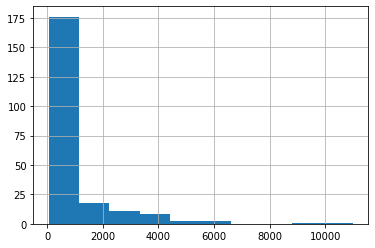

In [ ]:
df_prod['price_brl'].hist()

Temos predominio de vinho tinto, representando 60% do total do estoque, e vinho branco 31%.



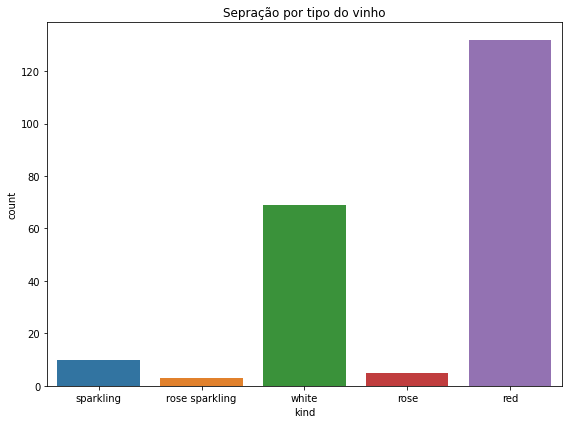

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))


sns.countplot(x='kind', data=df_prod)
ax.set_title("Sepração por tipo do vinho")

plt.tight_layout()

In [ ]:
(df_prod['kind'].value_counts()/df_prod.shape[0])*100

red               60.273973
white             31.506849
sparkling          4.566210
rose               2.283105
rose sparkling     1.369863
Name: kind, dtype: float64

E em relação ao preço temos que, os vinhos tinto e branco representão juntos cerca de 96% do valor do dos produtos. Sendo assim, já sabemos que estão os produto que não podem faltar no estoque. 

In [ ]:
df_prod.groupby(["kind"])['price_brl'].sum()

kind
red               162476.2
rose                 895.2
rose sparkling      1462.8
sparkling           7096.8
white              39977.2
Name: price_brl, dtype: float64

In [ ]:
(df_prod.groupby(["kind"])['price_brl'].sum()/df_prod['price_brl'].sum())*100

kind
red               76.672918
rose               0.422447
rose sparkling     0.690299
sparkling          3.348997
white             18.865339
Name: price_brl, dtype: float64

Como já imaginado, ao olhar para matriz de correlação observamos que o preço do vinho possui forte correlação com preço.

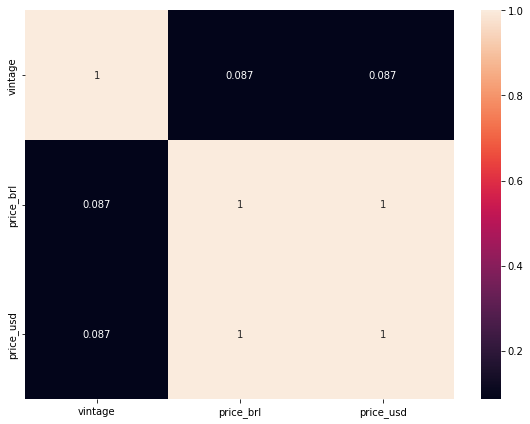

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

corr = df_prod.corr()
sns.heatmap(corr, annot=True, ax=ax)

plt.tight_layout()

###Resumo:

* Temos outliers nos preços, que estão atrelados aos vinhos francês;
* O preço do vinho possui forte correlação com a safra destaque;
* Dois tipo de vinho, tinto e branco, representam cerca de 96% do total do valor dos produtos. 

##Análise dos dados - Vendas

O segundo dataset é composto pelas vendas. Na coluna date temos as datas com frequencia de um dia. Existem a todo 720071 entrada, uma quantidade muito maior de entradas do que no outro dataset, isso ocorre porque segue a seguinte ordem:

* Descrição das vendas do item 1, do dia 01/01/2018 até 31/12/2020, na loja 1;
* Ao terminar o item 1, passa para o item 2 voltando para o dia 01/01/2018;
* Segue essa ordem até que seja descrito a venda dos 219 itens;
* Ao terminar todos os itens, volta para o começo, ou seja item 1, porém agora discriminandos as vendas da loja 2;
* Ao terminar a loja 2, repete a ordem para a loja 3.

In [ ]:
df_sells.shape

(720071, 4)

In [ ]:
df_sells.head()

,date,store,item,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10


In [ ]:
df_sells.tail()

,date,store,item,sales
720066,12/27/2020,3,219,71
720067,12/28/2020,3,219,28
720068,12/29/2020,3,219,75
720069,12/30/2020,3,219,135
720070,12/31/2020,3,219,91


In [ ]:
df_sells.nunique()

date     2192
store       3
item      219
sales     185
dtype: int64

Com esta rápida descrição abaixo vemos que os dadoos do dataset possuem formatos, int64(número) e object(texto). A coluna date necessita de tratamento, pois a informação contida nela não condiz com o formato dos dados, deverá ser transformada para o formato datetime. Além dessa, as colunas *item* e *store* também necessitam de que sejam arrumados os formatos.  

In [ ]:
df_sells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720071 entries, 0 to 720070
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    720071 non-null  object
 1   store   720071 non-null  int64 
 2   item    720071 non-null  int64 
 3   sales   720071 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.0+ MB


Primeiro foi trocado o nome da coluna *item* para *item_id*, e alterado os dados para string. Foi feito esse processo, para que ambos datasets tivessem um coluna com mesmo nome, e assim, fosse possível juntá-los posteriormente.

In [ ]:
df_sells.rename(columns={'item': 'item_id'}, inplace=True)
df_sells['item_id']=df_sells['item_id'].apply(lambda x: str(x))

In [ ]:
df_sells.head()

,date,store,item_id,sales
0,2018-01-01,1,1,13
1,2018-01-02,1,1,11
2,2018-01-03,1,1,14
3,2018-01-04,1,1,13
4,2018-01-05,1,1,10


In [ ]:
df_sells['store']=df_sells['store'].apply(lambda x: str(x))

Antes de arrumar a coluna será feito a junção dos datasets. Foi utilizado o método merge(), usando a coluna *item_id* como termo em comum, para associar os dados.

In [ ]:
merged = df_prod.merge(df_sells, on=['item_id'])

In [ ]:
merged

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,date,store,sales
0,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,2018-01-01,1,13
1,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,2018-01-02,1,11
2,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,2018-01-03,1,14
3,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,2018-01-04,1,13
4,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,2018-01-05,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
720066,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,12/27/2020,3,71
720067,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,12/28/2020,3,28
720068,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,12/29/2020,3,75
720069,219,Achaval-Ferrer Blend De Fincas Edição Limitada,Achaval Ferrer,Argentina,Mendoza,2014,red,999.0,172.84,12/30/2020,3,135


Para arrumar a divergência descrita acima foi utilizado método *to_datetime*, que propcia transformar para o formato de data, como a coluna possuia diferentes configurações de data, por exemplo dia/mês/ano e ano/dia/mês, não foi especificado com o formato presente, pois assim o método não consiguiria realizar a transformação. Assim a configuração final fico em ano/mês/dia, a coluna data foi alocada como index.

In [ ]:
#Arrumando datetime
merged.date = pd.to_datetime(merged.date)

In [ ]:
#colocar a coluna date como index
merged.index = merged.date
#retirar a coluna date
merged.drop('date', axis=1, inplace=True)

Temos um novo dataset como resultado da junção do df_prod e df_sells. Esse novo dataset possui a mesma quantidade de entrada do df_sells, ou seja 72071 entrada,porém com 11 colunas ao todo. Cada coluna está com o devido formato para os dados que nelas estão presente.

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720071 entries, 2018-01-01 to 2020-12-31
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item_id    720071 non-null  object 
 1   name       720071 non-null  object 
 2   producer   720071 non-null  object 
 3   country    720071 non-null  object 
 4   region     720071 non-null  object 
 5   vintage    720071 non-null  int64  
 6   kind       720071 non-null  object 
 7   price_brl  720071 non-null  float64
 8   price_usd  720071 non-null  float64
 9   store      720071 non-null  object 
 10  sales      720071 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 65.9+ MB


In [ ]:
merged.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales
date,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10


Por algum motivo temos uma data "perdida" no meio do Dataset. Como esta data de 2016 é a unica no data set ela será retirada, para não prejudicar a dimensão de tempo, que são dias corridos, do dataset.

In [ ]:
merged.index.min()

Timestamp('2016-01-01 00:00:00')

In [ ]:
merged.drop(index= '2016-01-01' , inplace=True)

Foi criado uma nova coluna, chamada *total_billed*, para demonstra o faturamento total no dia descrito, esse resultado foi obtido a partir da multiplicação do número de vendas pelo preço do vindo.

In [ ]:
merged['total_billed'] = merged['price_brl'] * merged['sales']
merged.head()

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,4414.8
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11,3735.6
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14,4754.4
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,4414.8
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,3396.0


Ao olhar para descrição estatística de vendas, observamos que todos os produtos tiveram pelo menos uma venda, no seu pior dia. Outro ponto importante a ser observado, o produto de maior faturamento não é o mesmo produto que foi mais vezes vendido, ambos parâmetros levando em consideração um unico dia. O produto de maior faturamento possui de 150 vendas, enquanto que o produto de maior número de vendas foi de 19. Esse ponto corrobora umas das premissas iniciais.

In [ ]:
round(merged[['total_billed', 'sales']].describe())

,total_billed,sales
count,719922.0,719922.0
mean,70158.0,71.0
std,129182.0,41.0
min,53.0,1.0
25%,13028.0,35.0
50%,29198.0,67.0
75%,66056.0,104.0
max,1648800.0,196.0


In [ ]:
print('Esse produto de maior faturamento do estoque. Em {} oportunidades este faturamento foi repetido\n'
      .format(len(merged.loc[merged['total_billed'] == merged['total_billed'].max()])))
merged.loc[merged['total_billed'] == merged['total_billed'].max()][:1]

Esse produto de maior faturamento do estoque. Em 16 oportunidades este faturamento foi repetido



,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2018-10-14,94,Domaine Ponsot Clos de La Roche Grand Cru Cuve...,Domaine Ponsot,France,Burgundy,2017,red,10992.0,1901.73,1,150,1648800.0


In [ ]:
print('Esse produto de menor faturamento do estoque. Em {} oportunidades este faturamento foi repetido\n'
      .format(len(merged.loc[merged['total_billed'] == merged['total_billed'].min()])))
merged.loc[merged['total_billed'] == merged['total_billed'].min()][:1]

Esse produto de menor faturamento do estoque. Em 20 oportunidades este faturamento foi repetido



,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2019-01-21,178,Cava Juvé & Camps Cinta Purpura Reserva Brut -...,Juvé & Camps,Spain,Penedès,0,sparkling,52.8,9.13,1,1,52.8


In [ ]:
print('Esse produto que mais vezes vendeu estoque. Em {} oportunidades este faturamento foi repetido\n'
      .format(len(merged.loc[merged['sales'] == merged['sales'].max()])))
merged.loc[merged['sales'] == merged['sales'].max()][:1]

Esse produto que mais vezes vendeu estoque. Em 1 oportunidades este faturamento foi repetido



,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2020-07-05,15,Nicolas Joly Clos de La Coulee De Serrant,Nicolas JOLY,France,Loire Valley,2018,white,785.4,135.88,2,196,153938.4


O valor total arrecado com as vendas durante os dois anos foi um pouco mais de 50 bilhões de reais.

In [ ]:
merged['total_billed'].sum()

50508477251.6

Os gráficos a seguir monstram os vinhos que tiverão melhores desempenho de venda e faturamento, não apenas em um dia, mas, dentro do intervalo dos dois anos do dataset. O agrupamento foi realizado pelo *item_id*, pois são valores únicos. Observamos que os vinhos de maior faturamento em dia unico, é o mesmo do de maior faturamento nos dois anos; e que o vinho maior vendas em dia único não aparece entre os 10 primeiros no intervalo de 2 anos.

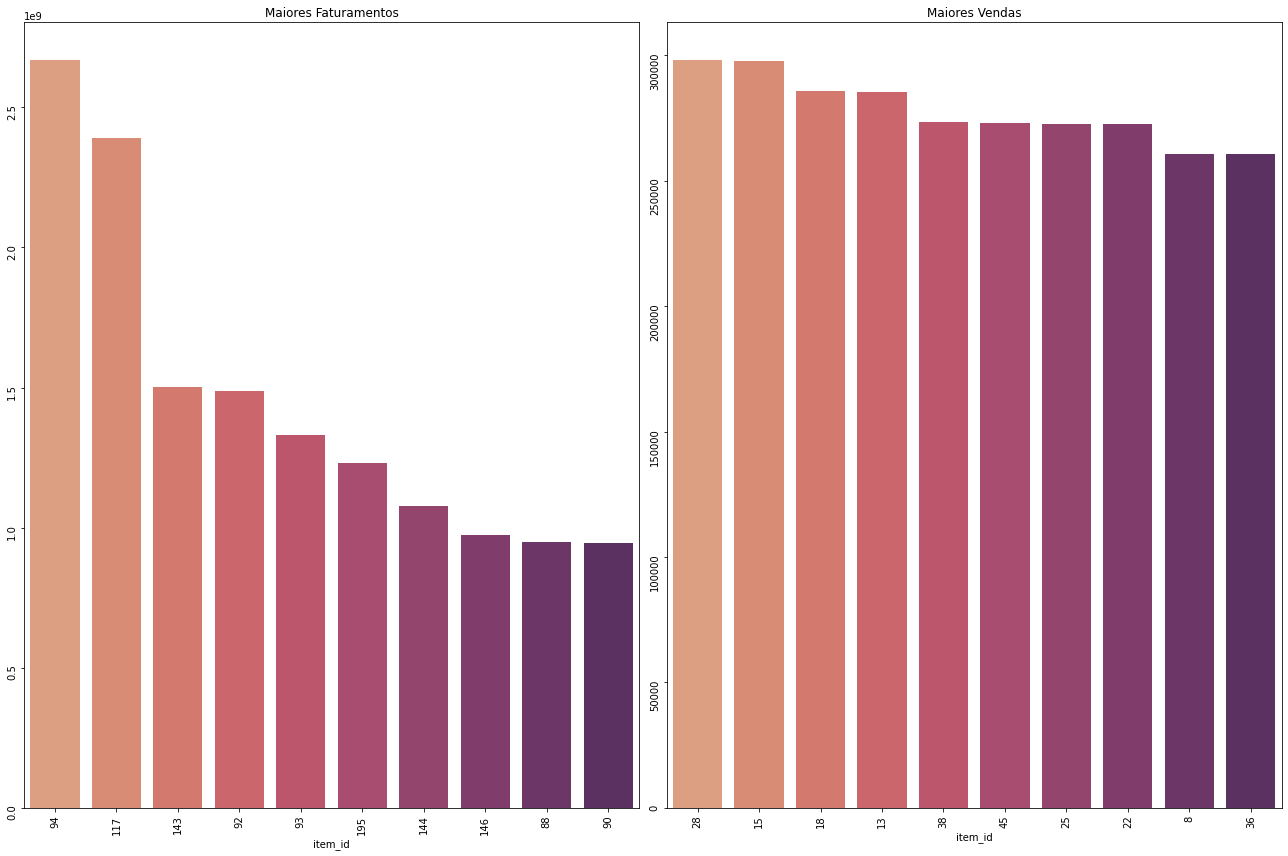

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(18,12))

billed_10 = merged.groupby('item_id')['total_billed'].sum().sort_values(ascending=False)[:10]
sns.barplot(x = billed_10.index , y=billed_10.values, palette = 'flare', ax=ax[0])
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Maiores Faturamentos')

sales_10 = merged.groupby('item_id')['sales'].sum().sort_values(ascending=False)[:10]
sns.barplot(x = sales_10.index , y=sales_10.values, palette = 'flare', ax=ax[1])
ax[1].tick_params(labelrotation=90)
ax[1].set_title('Maiores Vendas')

fig.tight_layout()

In [ ]:
# verificando o vinho de maior venda
merged.loc[merged['item_id']== '28'][:1]

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2018-01-01,28,La Chablisienne Chablis 1er Cru Côte De Léchet,La Chablisienne,France,Burgundy,2017,white,235.8,40.8,1,49,11554.2


A seguir vemos as menores vendas e faturamentos.

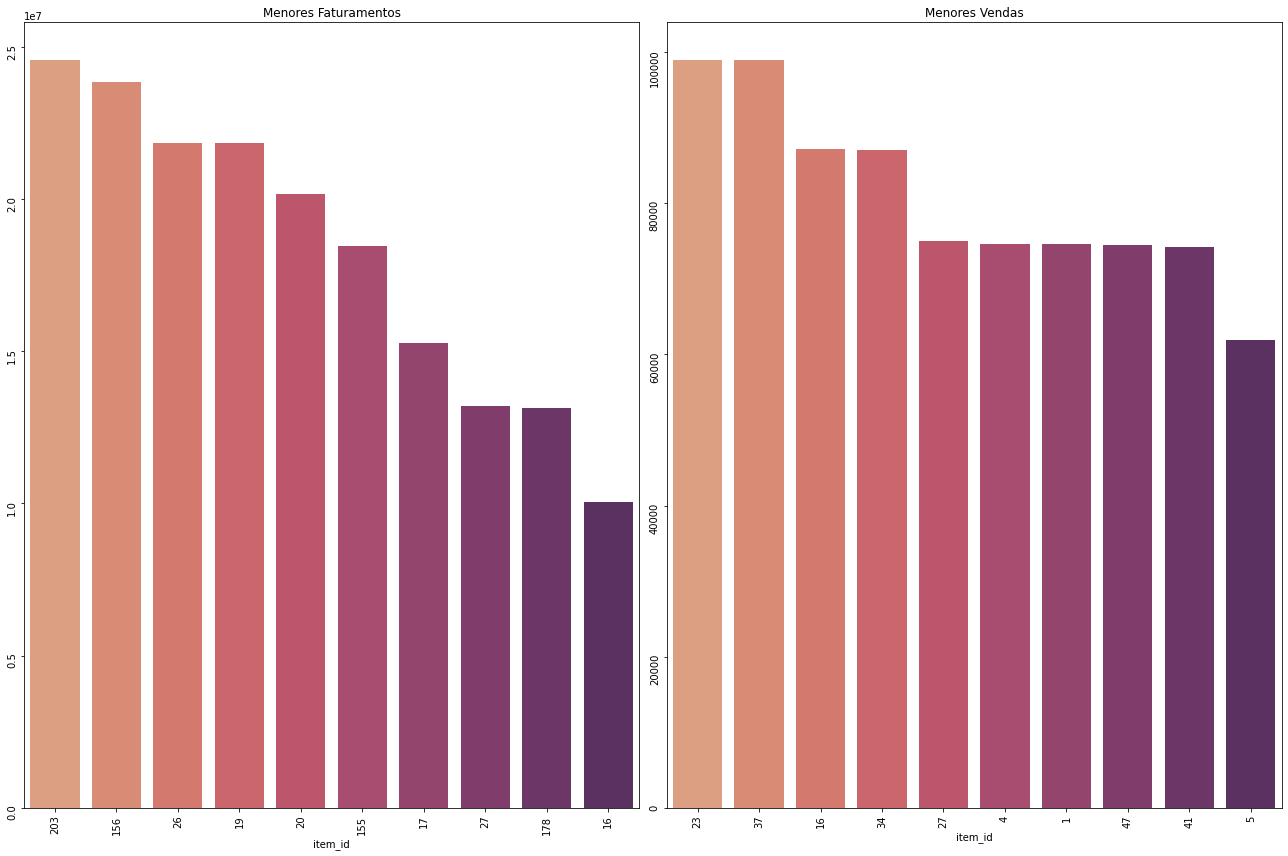

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize=(18,12))

billed_10 = merged.groupby('item_id')['total_billed'].sum().sort_values(ascending=False)[-10:]
sns.barplot(x = billed_10.index , y=billed_10.values, palette = 'flare', ax=ax[0])
ax[0].tick_params(labelrotation=90)
ax[0].set_title('Menores Faturamentos')

sales_10 = merged.groupby('item_id')['sales'].sum().sort_values(ascending=False)[-10:]
sns.barplot(x = sales_10.index , y=sales_10.values, palette = 'flare', ax=ax[1])
ax[1].tick_params(labelrotation=90)
ax[1].set_title('Menores Vendas')

fig.tight_layout()

In [ ]:
#Verificando vinho de menor faturamento 
merged.loc[merged['item_id']=='16'][:1]

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2018-01-01,16,Mirabeau Classic,Mirabeau,France,Provence,2019,rose,115.2,19.93,1,14,1612.8


In [ ]:
#Verificando vinho de menor venda
merged.loc[merged['item_id']=='5'][:1]

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed
date,,,,,,,,,,,,
2018-01-01,5,Philipponnat Clos Des Goisses Brut,Philipponat,France,Champagne,2009,sparkling,1548.0,267.82,1,11,17028.0


O faturamento da emrpesa de forma diária vemos que, o dia 27/06/2020 é o de maior faturamento com aproximadamente 53 milhões de reais; enquanto que o dia 29/02/2020 apresenta o menor faturamento com aproximadamente 39 milhões de reais. Essas duas data apresenta um distância representativa para a média de vendas, que fica em 46 milhões de reais. 

In [ ]:
billed_by_year = merged.groupby(merged.index)['total_billed'].sum()

In [ ]:
round(billed_by_year.describe())

count        1096.0
mean     46084377.0
std       2151602.0
min      39591014.0
25%      44630202.0
50%      46058883.0
75%      47477053.0
max      53332580.0
Name: total_billed, dtype: float64

In [ ]:
billed_by_year.sort_values(ascending= False)[:5]


date
2020-06-27    53332580.4
2019-09-27    52538163.4
2020-04-11    52151599.0
2019-07-26    52048251.7
2018-05-25    52039069.4
Name: total_billed, dtype: float64

In [ ]:
billed_by_year.sort_values(ascending=False)[-5:]

date
2018-12-11    40485274.2
2018-01-01    40454273.6
2018-11-15    40312737.6
2019-10-27    40212807.2
2020-02-29    39591013.8
Name: total_billed, dtype: float64

Com uma análise visual rápida no gráfico a seguir, podemos dizer que aparetemente o mês de entre Maio e Setembro apresentam uma tendência de aumento no faturamento. Os períodos festivos de final de ano, apresentam um momento de baixa no faturamento, fato que não confirma a premissa inicial de vendas altas no final do ano. Outro ponto aperente no gráfico, é uma tendêcia de aumento de faturamente de um ano para o outro.

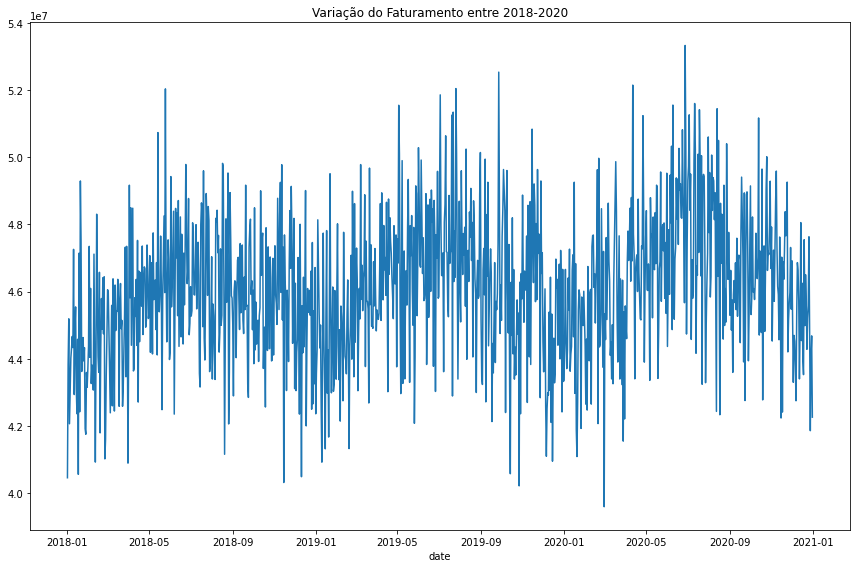

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x=billed_by_year.index, y= billed_by_year.values)
plt.title("Variação do Faturamento entre 2018-2020")

plt.tight_layout()

Olhando para as vendas totais por dia, a tendência observada no gráfico acima se mantem. O dia de menor vendas coincide com o dia de menor fauramento, no entanto, o mesmo não se mantem para maior número de vendas.

In [ ]:
sells_by_day = merged.groupby(merged.index)['sales'].sum()

In [ ]:
round(sells_by_day.describe())

count     1096.0
mean     46370.0
std       2136.0
min      38322.0
25%      44834.0
50%      46327.0
75%      47700.0
max      52901.0
Name: sales, dtype: float64

In [ ]:
sells_by_day.sort_values(ascending=False)[:5]

date
2020-07-05    52901
2019-06-01    52847
2020-07-11    52682
2019-07-20    52287
2020-07-18    52039
Name: sales, dtype: int64

In [ ]:
sells_by_day.sort_values(ascending=False)[-5:]

date
2019-01-30    41874
2019-12-29    41854
2018-01-23    41797
2019-12-08    41659
2020-02-29    38322
Name: sales, dtype: int64

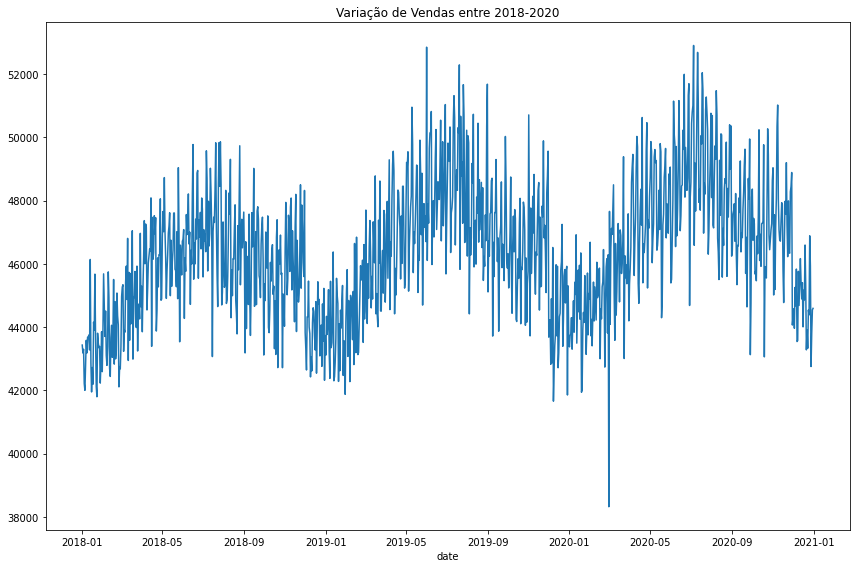

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(x=sells_by_day.index, y= sells_by_day.values)
plt.title("Variação de Vendas entre 2018-2020")

plt.tight_layout()

A seguir foram criadas algumas colunas para termos acesso facilitado aos valores mensais, aos dias da semana, e posteriormente aos finais de semana. A coluna *day_of_week* é preenchida com valores que vão 0 até 6, sendo segunda-feira representado pelo 0 e o domingo representado pelo 6. A coluna *weekend* será criada na sequência, os dias da semana são representados por 0 e os finais de semana por 1.

In [ ]:
merged['year'] = merged.index.year
merged['month'] = merged.index.month
merged['day'] = merged.index.day
merged['day_of_week'] = merged.index.dayofweek

In [ ]:
merged.head(8)

,item_id,name,producer,country,region,vintage,kind,price_brl,price_usd,store,sales,total_billed,year,month,day,day_of_week
date,,,,,,,,,,,,,,,,
2018-01-01,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,4414.8,2018,1,1,0
2018-01-02,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,11,3735.6,2018,1,2,1
2018-01-03,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,14,4754.4,2018,1,3,2
2018-01-04,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,13,4414.8,2018,1,4,3
2018-01-05,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,3396.0,2018,1,5,4
2018-01-06,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,12,4075.2,2018,1,6,5
2018-01-07,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,10,3396.0,2018,1,7,6
2018-01-08,1,Philipponnat Royale Reserve Brut,Philipponat,France,Champagne,0,sparkling,339.6,58.75,1,9,3056.4,2018,1,8,0


In [ ]:
merged['weekend'] = 0
merged.loc[(merged['day_of_week'] == 5) | (merged['day_of_week'] == 6), 'weekend'] = 1

Vemos que proporcionalmente, tanto faturamento quanto quantidade de vendas, são muito maiores durante a semana do que os finais de semana, mas quando olhamos para cada dia individualmente Sábado apresenta valores ligeramente maiores do que os demais dias. 

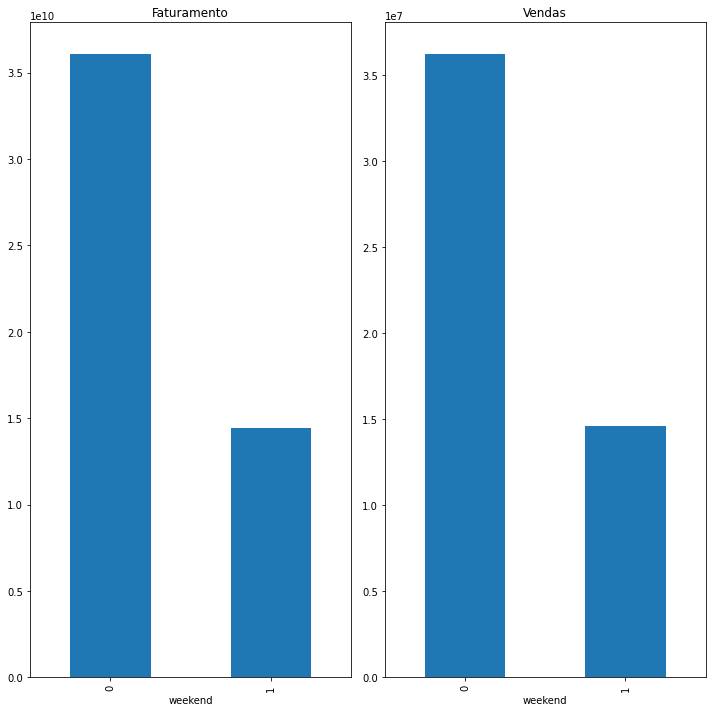

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

billed_weekend = merged.groupby('weekend')['total_billed'].sum()
billed_weekend.plot(kind='bar', ax=ax[0])

ax[0].set_title('Faturamento')

sales_weekend = merged.groupby('weekend')['sales'].sum()
sales_weekend.plot(kind='bar', ax=ax[1])

ax[1].set_title('Vendas')

plt.tight_layout()

In [ ]:
merged.groupby('day_of_week')['sales'].sum().sort_values(ascending=False)

day_of_week
5    7456051
4    7365157
3    7309705
2    7235282
1    7183047
0    7137119
6    7135384
Name: sales, dtype: int64

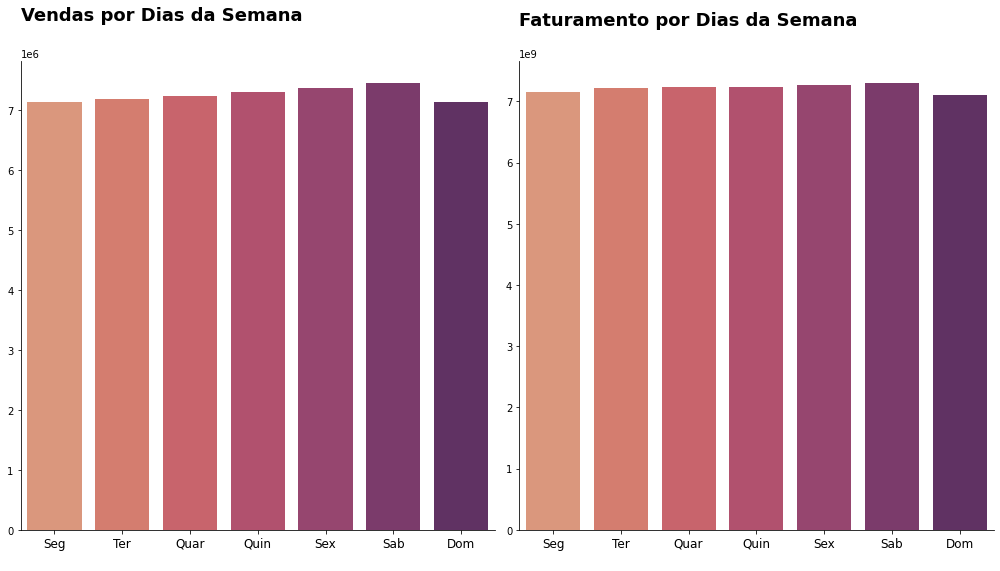

In [ ]:
fig,ax = plt.subplots(nrows =1, ncols=2, figsize=(14,8))

sales_day = merged.groupby('day_of_week')['sales'].sum()
sns.barplot(x=sales_day.index, y=sales_day.values, palette='flare', ax=ax[0])

#retirar margem
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

#retirar titulo automático
ax[0].set_xlabel(' ')

#formatar labels 
ax[0].set_xticklabels(labels=['Seg', 'Ter', 'Quar', 'Quin', 'Sex', 'Sab', 'Dom', ], fontsize = 12)

#título e subtítulo
ax[0].text(-0.5, 8500000, 'Vendas por Dias da Semana', fontsize=18, fontweight='bold')

#gráfico 2
billed_day = merged.groupby('day_of_week')['total_billed'].sum()
sns.barplot(x=billed_day.index, y=billed_day.values, palette='flare', ax=ax[1])

#retirar margem
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#retirar titulo automático
ax[1].set_xlabel(' ')

#formatar labels 
ax[1].set_xticklabels(labels=['Seg', 'Ter', 'Quar', 'Quin', 'Sex', 'Sab', 'Dom', ], fontsize = 12)

#título e subtítulo
ax[1].text(-0.5, 8250000000, 'Faturamento por Dias da Semana', fontsize=18, fontweight='bold')

plt.tight_layout()

Conforme foi observado no gráfico de Faturamento 2018-2020, realmente existe um aumento nas vendas e no faturamento com o passar dos anos.

In [ ]:
merged.groupby('year')['sales'].sum()

year
2018    16626132
2019    16998825
2020    17196788
Name: sales, dtype: int64

In [ ]:
round(merged.groupby('year')['total_billed'].sum())

year
2018    1.665165e+10
2019    1.683117e+10
2020    1.702565e+10
Name: total_billed, dtype: float64

In [ ]:
round(merged.groupby(['year', 'month'])['total_billed'].sum())

year  month
2018  1        1.364620e+09
      2        1.245092e+09
      3        1.387039e+09
      4        1.376895e+09
      5        1.434527e+09
      6        1.398402e+09
      7        1.438352e+09
      8        1.431237e+09
      9        1.376740e+09
      10       1.410908e+09
      11       1.393468e+09
      12       1.394374e+09
2019  1        1.379945e+09
      2        1.260314e+09
      3        1.427663e+09
      4        1.395295e+09
      5        1.446354e+09
      6        1.414327e+09
      7        1.474112e+09
      8        1.457993e+09
      9        1.380958e+09
      10       1.413311e+09
      11       1.406281e+09
      12       1.374620e+09
2020  1        1.393183e+09
      2        1.318615e+09
      3        1.413868e+09
      4        1.409745e+09
      5        1.457578e+09
      6        1.443294e+09
      7        1.486899e+09
      8        1.468649e+09
      9        1.389356e+09
      10       1.454853e+09
      11       1.394114e+09
      12

Ao olhar para o faturamento das lojas, existe um aumento anual também, sendo que a loja 2 a tem o maior faturamento.

In [ ]:
round(merged.groupby(['store','year'])['total_billed'].sum())

store  year
1      2018    5.448176e+09
       2019    5.484549e+09
       2020    5.569454e+09
2      2018    5.625640e+09
       2019    5.721684e+09
       2020    5.771143e+09
3      2018    5.577839e+09
       2019    5.624940e+09
       2020    5.685051e+09
Name: total_billed, dtype: float64

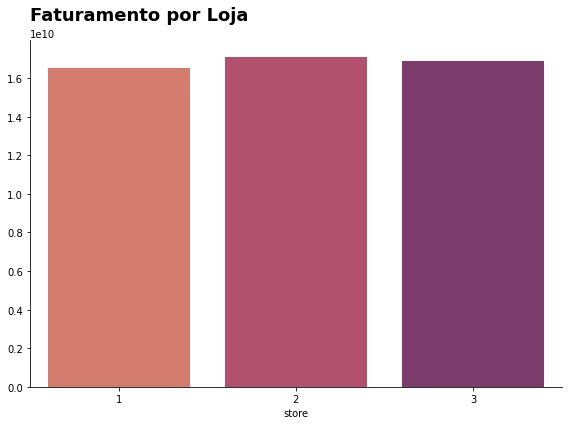

In [ ]:
fig,ax=plt.subplots(figsize=(8,6))

store = merged.groupby('store')['total_billed'].sum()
sns.barplot(x=store.index, y=store.values, palette='flare')

#retirar margem
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#título e subtítulo
ax.text(-0.5, 19000000000, 'Faturamento por Loja', fontsize=18, fontweight='bold')

plt.tight_layout()

###Resumo:

* A premissa inicial de vinho mais caro não é ser o que mais vende, é confirmada, porém, o mais barato não seje a mesma lógica;
* Os período de final de ano e início de ano, são os períodos de baixa;
* Sábado é o dia da semana de maior faturamento;
* A dataset aparenta ter tendência de alta e sazionalidade.

##Previsões

A previsão a ser realizada nesse projeto, é de carater temporal, desta forma lidaremos com uma TimeSeries. Para podermos realizar a previsão de forma adequada, devemos verificar se a nossa série de tempo, é estacionaria ou não. Para exemplificar temos a figura a seguir, que mostra que apenas a opção C é considerada estácionaria, pois a serie temporal não possui tendência de alta ou baixa, possui variância relativamente constante.

 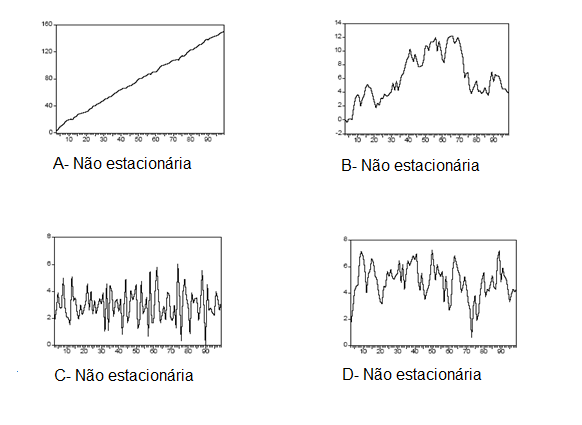

Os gráficos e alguns dados observados nas análises anteriores, já dão um certo indício de que, os dados que estamos trabalhando não são estacionários. Para confirmar essa suspeita, será uutilizado um método estatístico denominado ADF. Os pontos importantes a serem destados:

* Após o teste ser realizado, se o valor do *p-value* for igual o menor que um valor de significância, podemos rejeitar a hipótese inicial de que a serie não estacionária;

* Quanto menor o valor do *p-value* que obtivermos, maior a o intervalo de confiança que teremos para rejeitar a hipótese inicial;

* Mesmo que o de teste fique acima do valor crítico para rejeitar a hipótese inicial, isso não necessariamente quer dizer que a série não é estacionaria. 

O ADF servirá apenas para o teste de série temporal, para realizarmos a previsão em si, será utilizado biblioteca Prophet desenvolvida pelo Facebook. A biblioteca possui caminho fácil e rápido para realizar essa análise. A unica exigência dessa ferramenta, o dataset utilizado deve possui apenas duas colunas *Ds* com as data e *Y* com valor alvo da previsão. Com isso em mente, foi criado um novo dataset chamado **ts** com as vendas sendo atribuidas na coluna *Y*.

In [ ]:
ts_grouped = merged.groupby(merged.index)['sales'].sum()

#criando novo dataframe
ts = pd.DataFrame()
ts['ds'] = ts_grouped.index
ts['y']= ts_grouped.values

ts.head()

,ds,y
0,2018-01-01,43432
1,2018-01-02,43181
2,2018-01-03,43298
3,2018-01-04,42216
4,2018-01-05,42001


###Previsão Série Não Estacionária 
Ao aplicar o ADF o resultado mostra o que já havia sido observado anteriormente, a série com a qual estamos trabalhando não pode ser considerada estacionária. Mesmo com resultado do valor do teste estatístico ser próximo dos valores críticos, trabalhariamos com um intervalo de confiança próximo de 15% , mesmo com este resultado nesse teste feita a previsão para termos fazermos uma comparação.

In [ ]:
X = ts['y']

In [ ]:
result =adfuller(X)

print('ADF')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

ADF
Teste Estatístico: -2.3601
Valor-p: 0.1533
Valores Críticos:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


Para iniciarmos os passos necesários, primeiros precisamos instancear o prophet. Um objeto instanceado so pode fazer uma previsão, deste forma teremos que instancear um objeto diferente para a próxima previsão  

In [ ]:
m = Prophet()
m.fit(ts)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8t7umykg/q2s0q1i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8t7umykg/dr3p19f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83672', 'data', 'file=/tmp/tmp8t7umykg/q2s0q1i1.json', 'init=/tmp/tmp8t7umykg/dr3p19f2.json', 'output', 'file=/tmp/tmp8t7umykg/prophet_modelcvp49i43/prophet_model-20230326234141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


O próximo passo, é selecionar um período de dias que queremos realizar a nossa análise, foi selecionar 180 dias. O método make_future_dataframe() irá criar as entradas até a data desejada. 

In [ ]:
future = m.make_future_dataframe(periods=180)
future.tail()

,ds
1271,2021-06-25
1272,2021-06-26
1273,2021-06-27
1274,2021-06-28
1275,2021-06-29


Por fim realizamos a previsão. O método predict cria diversos parâmentros nessa previsão, aqui olharemos a previsão, e os possíveis devios para cima e para baixo. 

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat','yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1271,2021-06-25,50432.858551,48884.305455,52072.771628
1272,2021-06-26,51032.713039,49475.566059,52674.586800
1273,2021-06-27,48994.096541,47484.593472,50558.825401
1274,2021-06-28,48750.365375,47177.252216,50219.456565
1275,2021-06-29,49060.123075,47441.621379,50593.347034


Os plots a seguir mostram as previsões que acabamos de reaizar. É possivel observar como a previsão começa a ter variação maior, entre variação para cima e baixo, conforme passa mais tempo, ou seja, quanto maior o tempo selecionado para realizar a previsão mais difícil de acertar. 

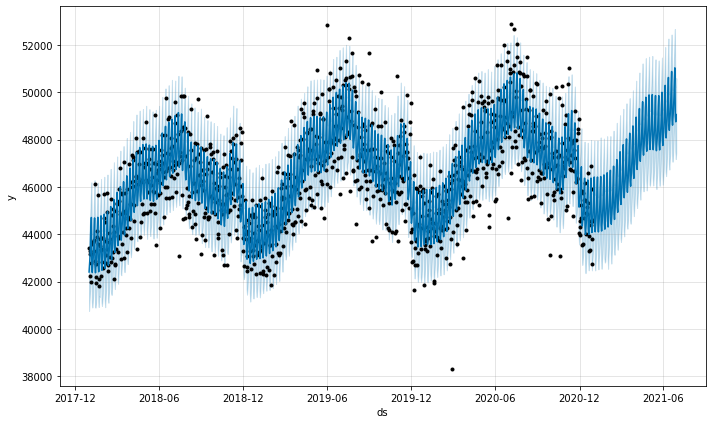

In [ ]:
fig1=m.plot(forecast)

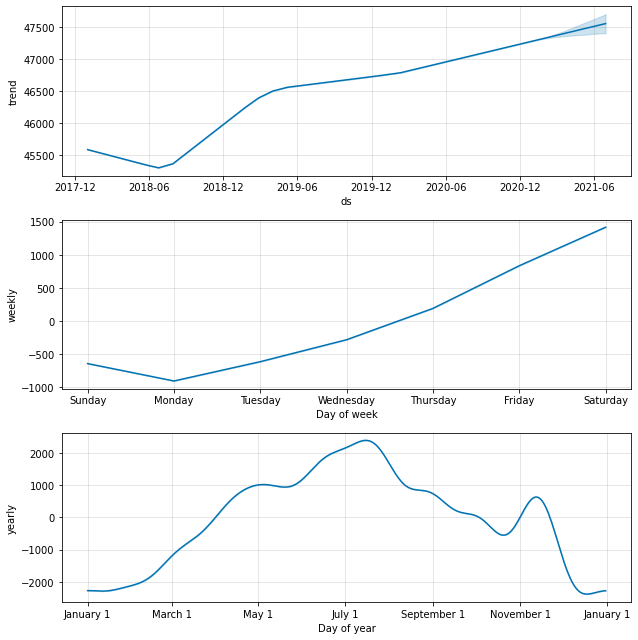

In [ ]:
fig2=m.plot_components(forecast)

Para ter uma ideia do desempenho dessas previsões, utilizei o MAE apartir da biblioteca do Sckit learn. A variável criada aqui, previsão, são as previsões feitas pela prophet sem os ultimos 180 dias, isso porque, se não forem retiradas o método não consegue comparar as duas séries, por uma ter mais dias. Então no erro, é comparado as previsão que foram feitas para os dias que já temos valores concretos. E o com o valor elevado do erro, fica nitido que essa previsão não nos ajudaria muito.   

In [ ]:
previsão = forecast[:-180]

In [ ]:
#calculo do erro médio absoluto
mean_absolute_error(ts['y'] , previsão['yhat'])

938.9657416800619

### Previsão Série Estacionária

Nessa etapa iremos tentar reduzir os efeitos da tendência de alta e de sazionalidade. Primeiro passo será aplicado método **log** nos dados, isso diminuirá a amplitude dos nossos dados. Precisaremos da média movel, aqui foi selecionado o período de 30 dias, e por fim será feita a subtração da média movel em relação ao log dos dados.


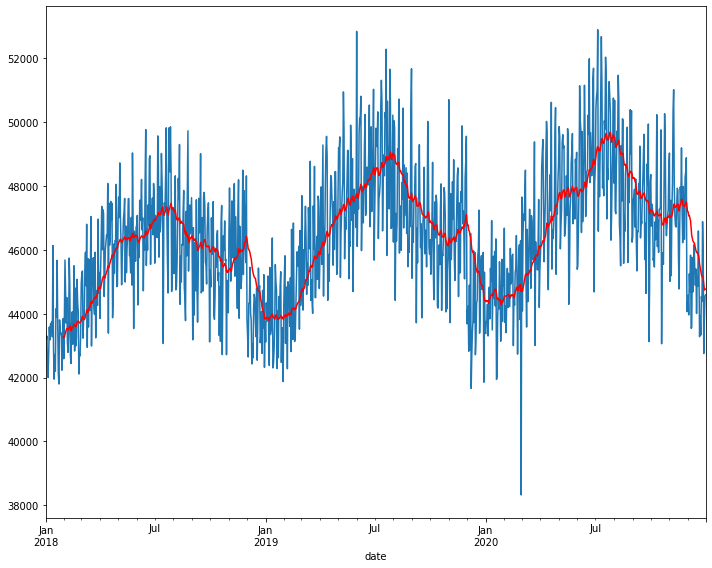

In [ ]:
#média movel 1 mês
ma = ts_grouped.rolling(30).mean()

fig, ax = plt.subplots(figsize=(10,8))
ts_grouped.plot(ax=ax)
ma.plot(ax=ax, color='r')
plt.tight_layout()

Ao aplicar método log, conseguimos diminuir a amplitude da variação dos dados. Agora o topo máximo está perto 11 e o mínimo está em 10,55.


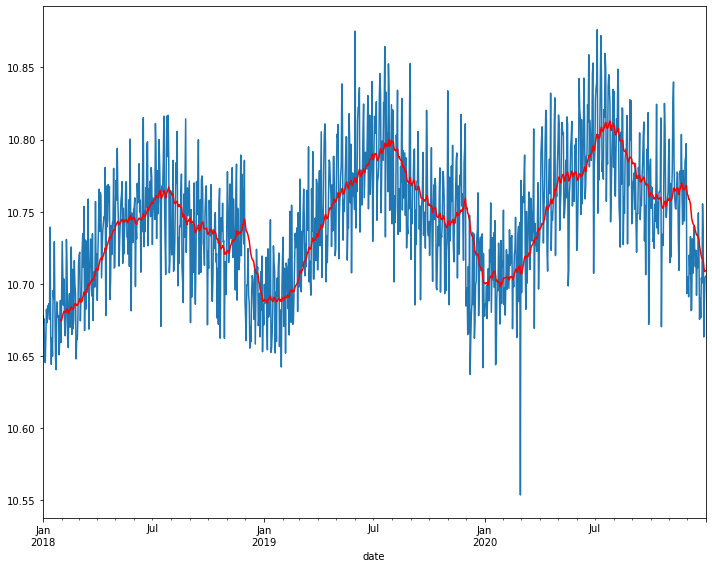

In [ ]:
ts_log=np.log(ts_grouped)
ma_log=ts_log.rolling(30).mean()

fig, ax = plt.subplots(figsize=(10,8))
ts_log.plot(ax=ax)
ma_log.plot(ax=ax, color='r')
plt.tight_layout()

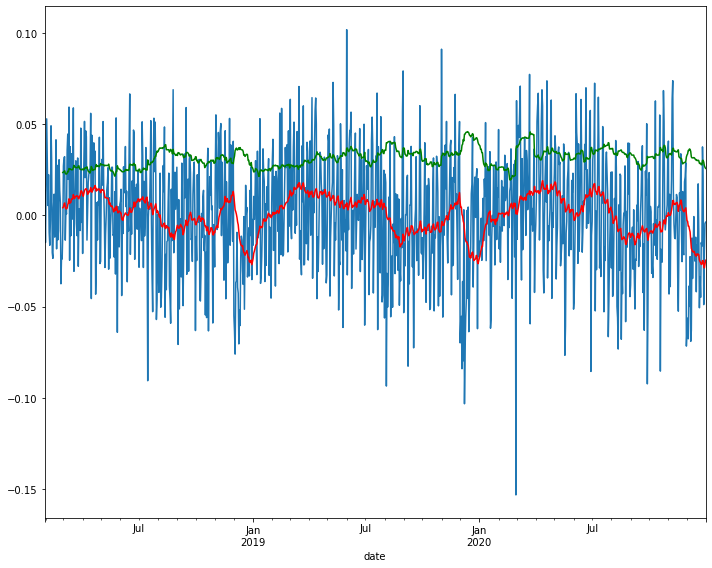

In [ ]:
ts_sub=(ts_log - ma_log).dropna()
ma_sub=ts_sub.rolling(30).mean()
std_sub=ts_sub.rolling(30).std()

fig, ax = plt.subplots(figsize=(10,8))
ts_sub.plot(ax=ax)
ma_sub.plot(ax=ax, color='r')
std_sub.plot(ax=ax, color='g')
plt.tight_layout()

Ao realizar o porcesso acima, vemos que o nosse teste estatístico atingiu valor que possibilita considerar a série temporal como estacionária. 

In [ ]:
X_sub= ts_sub.values

result_sub =adfuller(X_sub)

print('ADF')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.4f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

ADF
Teste Estatístico: -4.8494
Valor-p: 0.0000
Valores Críticos:
	1%: -3.4365
	5%: -2.8642
	10%: -2.5682


Será feita uma nova previsão utilizando ts_log. Como os passo a seguir são os mesmo já descritos acima, irei apenas repeti-los são explicá-los.

In [ ]:
#criando novo dataframe
ts_est = pd.DataFrame()
ts_est['ds'] = ts_log.index
ts_est['y'] = ts_log.values

In [ ]:
ts_est.head()

,ds,y
0,2018-01-01,10.678952
1,2018-01-02,10.673156
2,2018-01-03,10.675862
3,2018-01-04,10.650555
4,2018-01-05,10.645449


In [ ]:
c = Prophet()
c.fit(ts_est)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8t7umykg/9ct2l3vf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8t7umykg/el2xzw8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73877', 'data', 'file=/tmp/tmp8t7umykg/9ct2l3vf.json', 'init=/tmp/tmp8t7umykg/el2xzw8m.json', 'output', 'file=/tmp/tmp8t7umykg/prophet_modelxonlcch3/prophet_model-20230326234145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_est = c.make_future_dataframe(periods = 180)
future_est.tail()

,ds
1271,2021-06-25
1272,2021-06-26
1273,2021-06-27
1274,2021-06-28
1275,2021-06-29


In [ ]:
forecast_est= c.predict(future)
forecast_est[['ds', 'yhat','yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1271,2021-06-25,10.826564,10.795155,10.860630
1272,2021-06-26,10.839117,10.802944,10.873949
1273,2021-06-27,10.794943,10.760999,10.831074
1274,2021-06-28,10.790544,10.754597,10.826774
1275,2021-06-29,10.797265,10.763036,10.832382


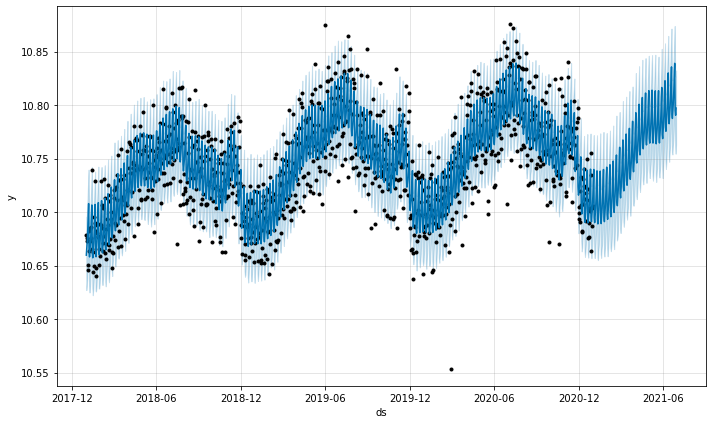

In [ ]:
fig1 = c.plot(forecast_est)

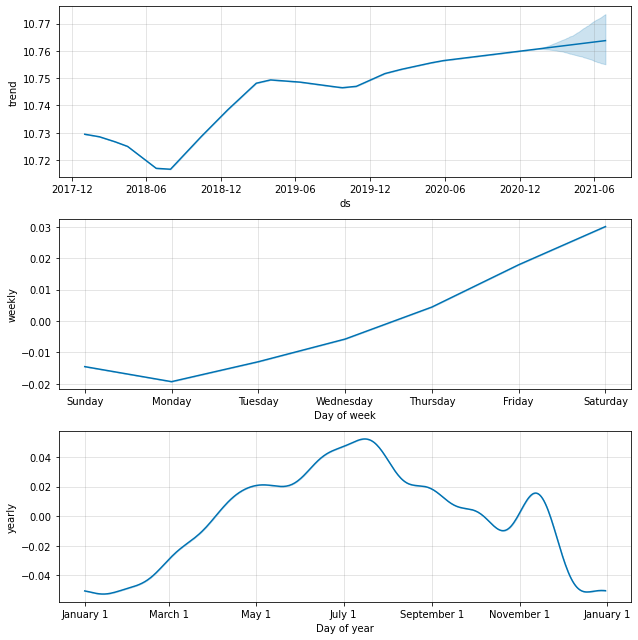

In [ ]:
fig2=c.plot_components(forecast_est)

In [ ]:
previsão_est = forecast_est[:-180]


Agora temos um previsão com erro muito, que poderá ser utlizada, uma vez, que se trata de uma série estacionária.

In [ ]:
mean_absolute_error(ts_est['y'], previsão_est['yhat'])

0.020105302611668468

Como resultado final será feito um DataFrame, com as data, a previsão, e o valor real. Será aplicado processo de exponenciação para retornar valor a escala real.

In [ ]:
df_final = forecast_est[['ds', 'yhat']]
df_final['RealAmount'] = ts_est['y'] 
df_final.head()

<ipython-input-96-1357c86ef911>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['RealAmount'] = ts_est['y']


,ds,yhat,RealAmount
0,2018-01-01,10.659755,10.678952
1,2018-01-02,10.665906,10.673156
2,2018-01-03,10.672902,10.675862
3,2018-01-04,10.682855,10.650555
4,2018-01-05,10.696066,10.645449


In [ ]:
df_final['RealAmount'] = np.exp(df_final['RealAmount'].values)
df_final['yhat'] = np.exp(df_final['yhat'].values)

<ipython-input-97-ea198b8cae3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['RealAmount'] = np.exp(df_final['RealAmount'].values)
<ipython-input-97-ea198b8cae3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['yhat'] = np.exp(df_final['yhat'].values)


In [ ]:
df_final.rename(columns={'yhat': 'Predict'}, inplace=True)
df_final.head()

<ipython-input-98-c571d939bcd5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={'yhat': 'Predict'}, inplace=True)


,ds,Predict,RealAmount
0,2018-01-01,42606.204081,43432.0
1,2018-01-02,42869.077752,43181.0
2,2018-01-03,43170.042796,43298.0
3,2018-01-04,43601.842002,42216.0
4,2018-01-05,44181.685975,42001.0


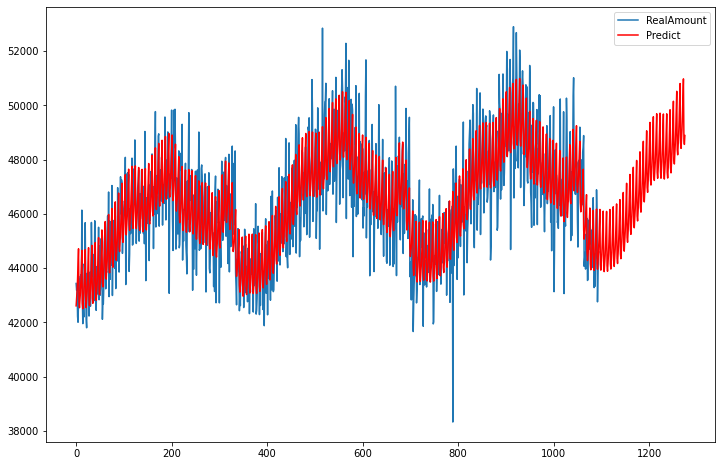

In [ ]:
# plotting predictions vs reality
fig, ax = plt.subplots(figsize=(12,8))
df_final['RealAmount'].plot(ax=ax, legend=('Real Amount'))
df_final['Predict'].plot(ax=ax, color='r', legend={'Predicted'})

plt.show()

##Conclusão

Nas análises explortórias foi possível observar que as premissas dos alta nas vendas períodos de final de ano e  vinhos com valores mais baixo teriam maior fluxo de vendas, não foram confirmadas. Os momentos de alta nas vendas acontecem em meio ao terceriro trimestre do ano, seguindo por momento de baixa na virada do ano. 

Quanto ao faturamento observou-se que o vinho mais caro, foi o que mais contribuiu para o faturamento no período de 2 anos, mesmo que esse não tenha sido o que mais foi vendido. Esse ponto confirma uma das premissas iniciais. Pensando no estoque, o tipo de vinhos que não podem acabar são os vinhos franceses, que possuem alta contribuição no faturamento, e o vinho branco de identificação 28, pois foi o mais vendido. 

As previsões se mostraram úteis ao transformar a série de não estacionária para estacionária, onde foi possível adquirir um intervalo de confiança superior a 95%. Com isso as previsões ficaram dentro da variação dos valores de venda, que já estava registrada nos dados históricos. 